# データ探索

このノートブックでは、Signateの電力価格予測コンペティションのデータを探索的に分析します。

## 1. 環境設定とデータ読み込み

In [1]:
# 自動ローディング
%load_ext autoreload
%autoreload 2

In [2]:
# アクティベート
!source ../../.venv/bin/activate

# 日本語フォントを簡単に使う
#!pip install japanize-matplotlib
import japanize_matplotlib

# 祝日取得
#!pip install holidays
import holidays

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# プロジェクトのルートディレクトリを設定
PROJECT_ROOT = Path.cwd().parent

# データディレクトリのパスを設定
DATA_DIR = PROJECT_ROOT / "data"

print(f"プロジェクトルートパス： ", PROJECT_ROOT)

# データ読み込み用の関数をインポート
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
from src.data_loader import load_data, preprocess_time, get_feature_groups, check_missing_values, check_outliers

プロジェクトルートパス：  /Users/m0122wt/Desktop/02.プライベート/01.ノウハウ/07.データ分析/notebook/signate_smbc_202506


### 1.1 データの読み込み

In [4]:
# データの読み込み
train_df, test_df, feature_desc = load_data(DATA_DIR)

print("訓練データの形状:", train_df.shape)
print("テストデータの形状:", test_df.shape)
print("\n特徴量の説明:")
print(feature_desc)

訓練データの形状: (26280, 91)
テストデータの形状: (8760, 90)

特徴量の説明:
                                           単位  \
特徴量名                                            
time                                        -   
generation_biomass                         MW   
generation_fossil_brown_coal/lignite       MW   
generation_fossil_gas                      MW   
generation_fossil_hard_coal                MW   
...                                       ...   
seville_weather_id                          -   
seville_weather_main                        -   
seville_weather_description                 -   
seville_weather_icon                        -   
price_actual                          EUR/MWh   

                                                                           説明  
特徴量名                                                                           
time                                  時間 (中央ヨーロッパ時間 にローカライズされたDatetimeインデックス)  
generation_biomass                            time列に記載の時刻の24時間前のバイオマス

### 1.2 時間特徴量の前処理

In [5]:
# 時間特徴量の前処理
train_df = preprocess_time(train_df, tz='Europe/Berlin')
test_df = preprocess_time(test_df, tz='Europe/Berlin')

# 時間関連の特徴量を確認
time_features = [col for col in train_df.columns if col in ['hour', 'day_of_week', 'month', 'year']]
print("時間関連の特徴量:")
print(time_features)

時間関連の特徴量:
['hour', 'day_of_week', 'month', 'year']


## 2. 基本情報の確認

### 2.1 データの基本情報

In [6]:
# 訓練データの基本情報
print("訓練データの基本情報:")
train_df.info()

# 数値型の基本統計量
print("\n数値型の基本統計量:")
train_df.describe()

訓練データの基本情報:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26280 entries, 2015-01-02 00:00:00+01:00 to 2017-12-31 23:00:00+01:00
Data columns (total 96 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation_biomass                           26259 non-null  float64
 1   generation_fossil_brown_coal/lignite         26260 non-null  float64
 2   generation_fossil_gas                        26260 non-null  float64
 3   generation_fossil_hard_coal                  26260 non-null  float64
 4   generation_fossil_oil                        26259 non-null  float64
 5   generation_hydro_pumped_storage_consumption  26259 non-null  float64
 6   generation_hydro_run_of_river_and_poundage   26259 non-null  float64
 7   generation_hydro_water_reservoir             26260 non-null  float64
 8   generation_nuclear                           26261 non-null  float64
 9   generation_ot

,generation_biomass,generation_fossil_brown_coal/lignite,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_hydro_pumped_storage_consumption,generation_hydro_run_of_river_and_poundage,generation_hydro_water_reservoir,generation_nuclear,generation_other,...,seville_rain_3h,seville_snow_3h,seville_clouds_all,seville_weather_id,price_actual,hour,day_of_week,month,day,year
count,26259.000000,26260.000000,26260.000000,26260.000000,26259.000000,26259.000000,26259.000000,26260.000000,26261.000000,26260.000000,...,26280.000000,26280.0,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000
mean,399.151719,480.261729,5559.830122,4447.482216,303.806009,504.322899,888.150844,2507.795316,6323.681200,62.500685,...,0.000243,0.0,13.740601,774.138927,56.028338,11.500000,3.005479,6.527740,15.746195,2016.000913
std,89.897230,365.334152,2272.017312,2027.884207,54.036443,804.870327,369.509637,1869.150134,827.939857,21.451727,...,0.003961,0.0,25.801707,85.866724,14.340356,6.922318,2.000487,3.446579,8.794406,0.815952
min,0.000000,0.000000,1518.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,200.000000,9.330000,0.000000,0.000000,1.000000,1.000000,2015.000000
25%,341.000000,0.000000,4071.000000,2624.000000,268.000000,0.000000,595.000000,955.000000,5900.000000,53.000000,...,0.000000,0.0,0.000000,800.000000,47.617500,5.750000,1.000000,4.000000,8.000000,2015.000000
50%,378.000000,564.000000,4866.000000,4764.000000,303.000000,90.000000,795.000000,1991.000000,6734.000000,58.000000,...,0.000000,0.0,0.000000,800.000000,55.930000,11.500000,3.000000,7.000000,16.000000,2016.000000
75%,480.000000,863.000000,6264.000000,6107.000000,336.000000,696.000000,1148.000000,3666.000000,7071.000000,84.000000,...,0.000000,0.0,20.000000,800.000000,65.192500,17.250000,5.000000,10.000000,23.000000,2017.000000
max,592.000000,999.000000,20034.000000,8359.000000,449.000000,4523.000000,1939.000000,9389.000000,7116.000000,106.000000,...,0.095000,0.0,100.000000,804.000000,116.800000,23.000000,6.000000,12.000000,31.000000,2017.000000


### 2.2 欠損値の確認

In [7]:
# 欠損値の確認
missing_values = check_missing_values(train_df, threshold=0.0)

欠損値があるカラム、欠損値の数、全レコードに対する割合:


,missing_count,missing_ratio
generation_biomass,21,0.000799
generation_fossil_brown_coal/lignite,20,0.000761
generation_fossil_gas,20,0.000761
generation_fossil_hard_coal,20,0.000761
generation_fossil_oil,21,0.000799
generation_hydro_pumped_storage_consumption,21,0.000799
generation_hydro_run_of_river_and_poundage,21,0.000799
generation_hydro_water_reservoir,20,0.000761
generation_nuclear,19,0.000723
generation_other,20,0.000761


## 3. 時系列データの分析

In [8]:
# 目的変数の設定
target = 'price_actual'

In [9]:
# 時系列データのチェック
train_df[time_features]

,hour,day_of_week,month,year
time,,,,
2015-01-02 00:00:00+01:00,0,4,1,2015
2015-01-02 01:00:00+01:00,1,4,1,2015
2015-01-02 02:00:00+01:00,2,4,1,2015
2015-01-02 03:00:00+01:00,3,4,1,2015
2015-01-02 04:00:00+01:00,4,4,1,2015
...,...,...,...,...
2017-12-31 19:00:00+01:00,19,6,12,2017
2017-12-31 20:00:00+01:00,20,6,12,2017
2017-12-31 21:00:00+01:00,21,6,12,2017


### 3.1 時間帯ごとの傾向

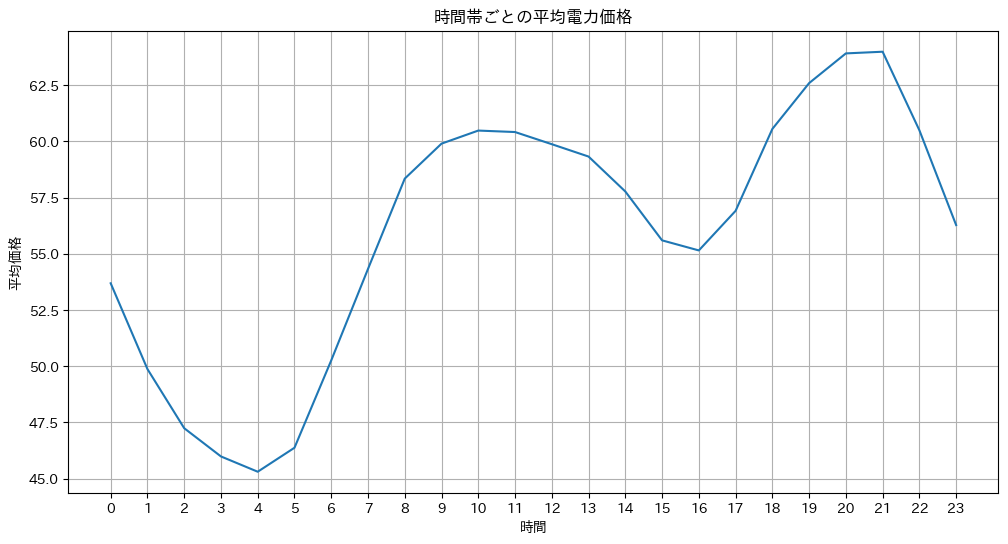

In [10]:
# 時間帯ごとの平均価格
plt.figure(figsize=(12, 6))
train_df.groupby('hour')[target].mean().plot(kind='line')
plt.title('時間帯ごとの平均電力価格')
plt.xlabel('時間')
plt.ylabel('平均価格')
plt.xticks(np.arange(0, 24, step=1))
plt.grid(True)
plt.show()

### 3.2 曜日別の傾向

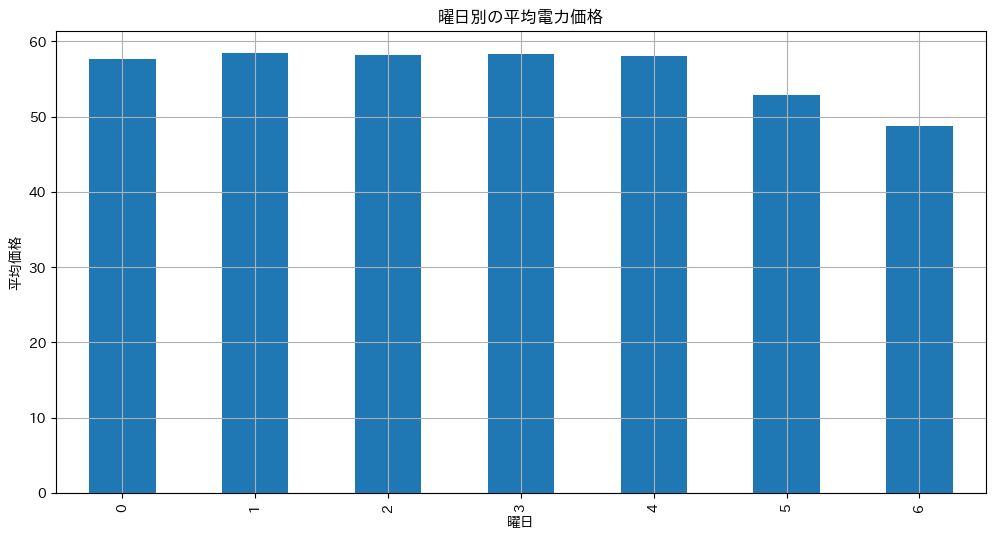

In [11]:
# 曜日別の平均価格
plt.figure(figsize=(12, 6))
train_df.groupby('day_of_week')[target].mean().plot(kind='bar')
plt.title('曜日別の平均電力価格')
plt.xlabel('曜日')
plt.ylabel('平均価格')
plt.grid(True)
plt.show()

### 3.3 月別の傾向

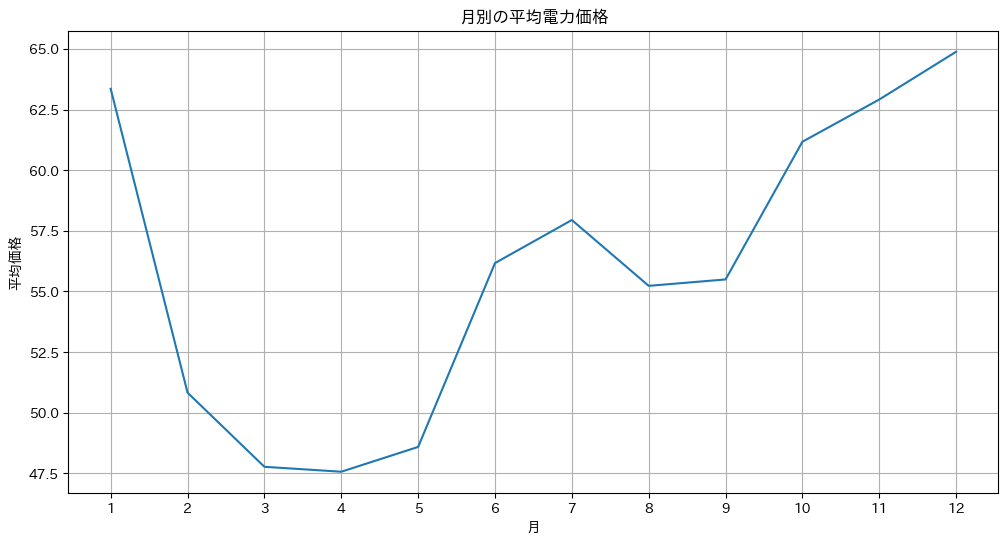

In [12]:
# 月別の平均価格
plt.figure(figsize=(12, 6))
train_df.groupby('month')[target].mean().plot(kind='line')
plt.title('月別の平均電力価格')
plt.xlabel('月')
plt.ylabel('平均価格')
plt.xticks(np.arange(1, 13, step=1))
plt.grid(True)
plt.show()

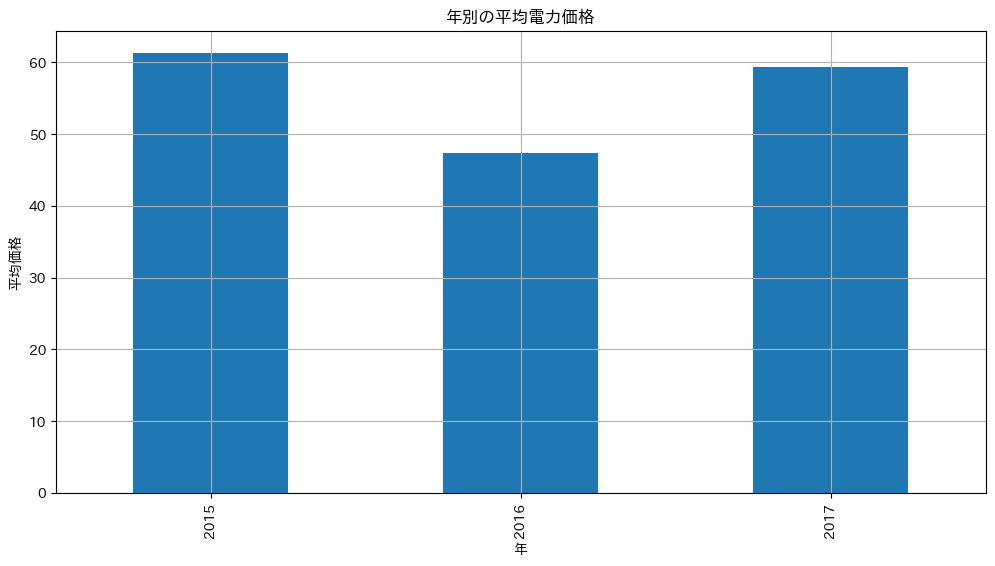

In [13]:
# 年別の平均電力価格
plt.figure(figsize=(12, 6))
train_df.groupby('year')[target].mean().plot(kind='bar')
plt.title('年別の平均電力価格')
plt.xlabel('年')
plt.ylabel('平均価格')
plt.grid(True)
plt.show()

## 4. 目的変数（電力価格）の分析

### 4.1 価格の分布

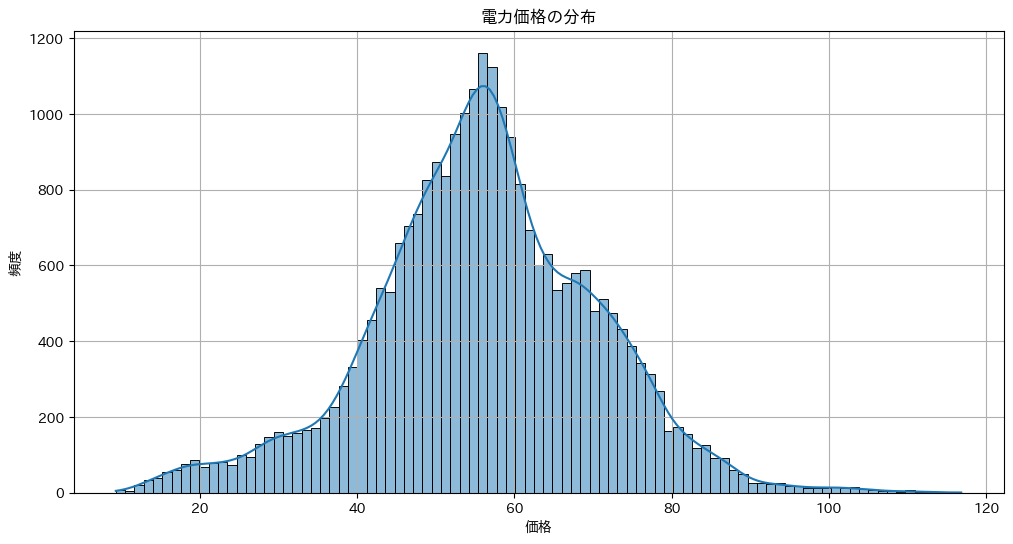

In [14]:
# 価格の分布
plt.figure(figsize=(12, 6))
sns.histplot(train_df[target], kde=True)
plt.title('電力価格の分布')
plt.xlabel('価格')
plt.ylabel('頻度')
plt.grid(True)
plt.show()

### 4.2 時系列での価格変動

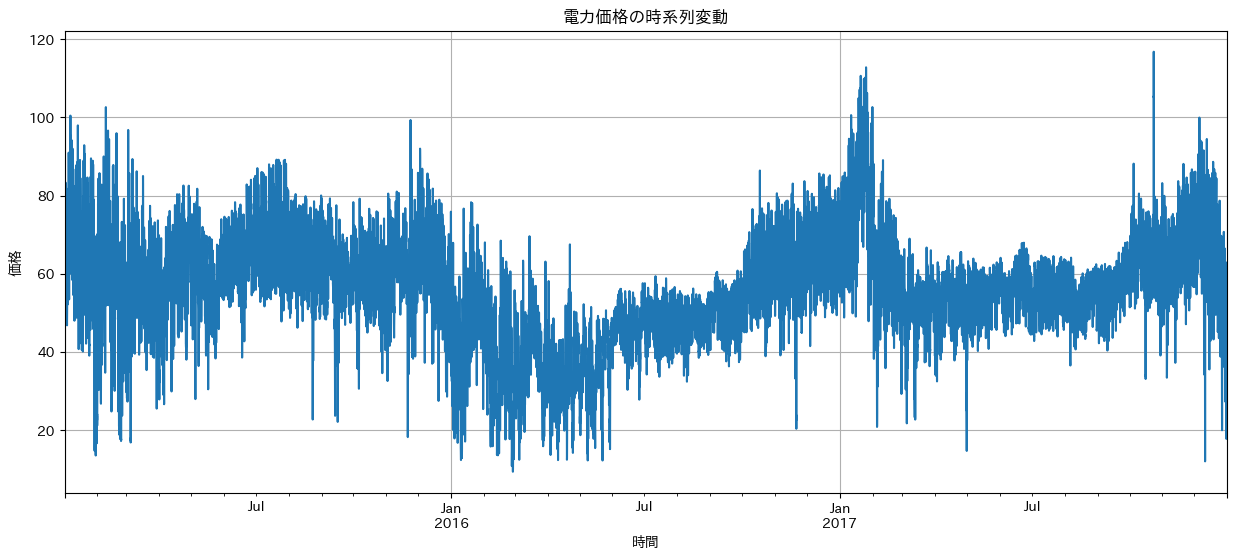

In [15]:
# 時系列での価格変動
plt.figure(figsize=(15, 6))
train_df[target].plot()
plt.title('電力価格の時系列変動')
plt.xlabel('時間')
plt.ylabel('価格')
plt.grid(True)
plt.show()

## 5. 特徴量の分析

### 5.1 特徴量のグループ化

In [16]:
# 特徴量のグループ化
feature_groups = get_feature_groups(train_df)
for group_name, features in feature_groups.items():
    print(f"\n{group_name}の特徴量:")
    print(features)


timeの特徴量:
['hour', 'day_of_week', 'month', 'day', 'year']

generationの特徴量:
['generation_biomass', 'generation_fossil_brown_coal/lignite', 'generation_fossil_gas', 'generation_fossil_hard_coal', 'generation_fossil_oil', 'generation_hydro_pumped_storage_consumption', 'generation_hydro_run_of_river_and_poundage', 'generation_hydro_water_reservoir', 'generation_nuclear', 'generation_other', 'generation_other_renewable', 'generation_solar', 'generation_waste', 'generation_wind_onshore']

weatherの特徴量:
['generation_wind_onshore', 'valencia_temp', 'valencia_temp_min', 'valencia_temp_max', 'valencia_pressure', 'valencia_humidity', 'valencia_wind_speed', 'valencia_wind_deg', 'valencia_rain_1h', 'valencia_rain_3h', 'valencia_snow_3h', 'valencia_clouds_all', 'madrid_temp', 'madrid_temp_min', 'madrid_temp_max', 'madrid_pressure', 'madrid_humidity', 'madrid_wind_speed', 'madrid_wind_deg', 'madrid_rain_1h', 'madrid_rain_3h', 'madrid_snow_3h', 'madrid_clouds_all', 'bilbao_temp', 'bilbao_temp_min', 'b

### 5.2 特徴量間の相関

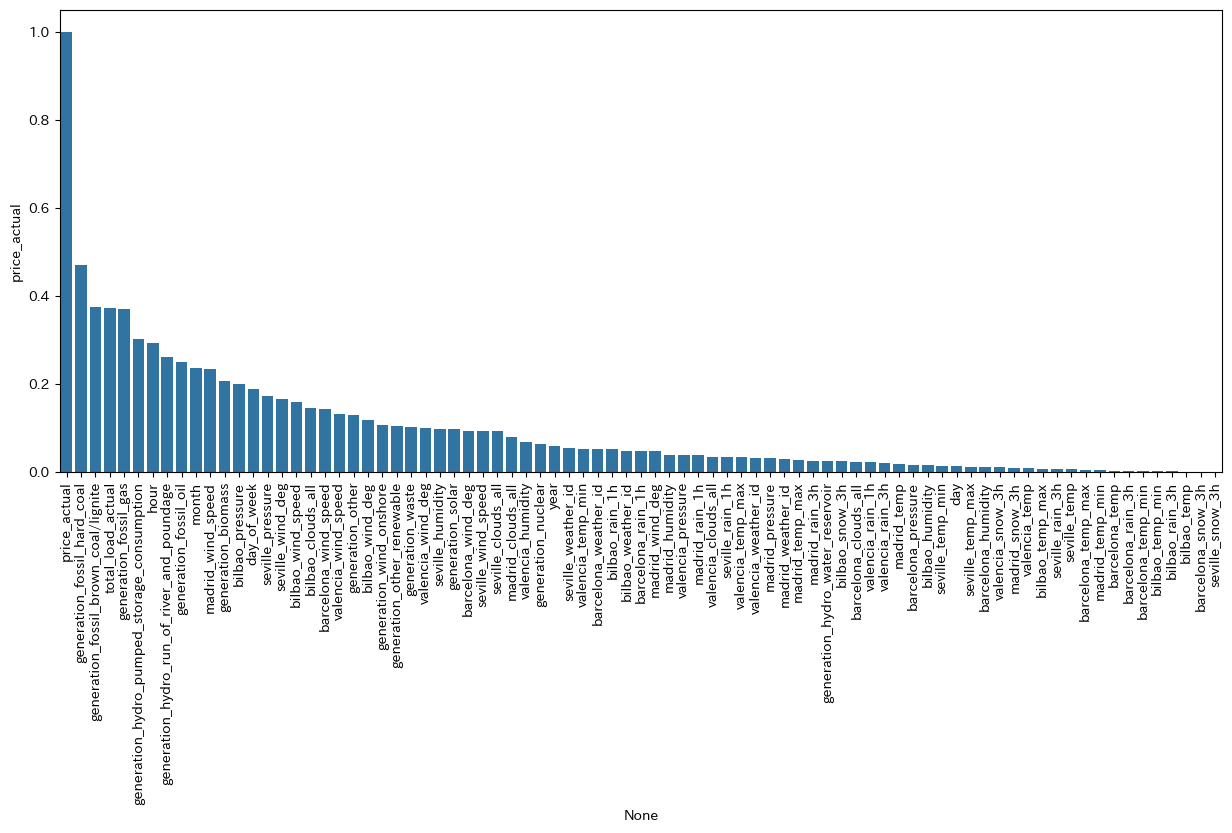

,generation_biomass,generation_fossil_brown_coal/lignite,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_hydro_pumped_storage_consumption,generation_hydro_run_of_river_and_poundage,generation_hydro_water_reservoir,generation_nuclear,generation_other,...,seville_rain_3h,seville_snow_3h,seville_clouds_all,seville_weather_id,price_actual,hour,day_of_week,month,day,year
generation_biomass,1.000000,0.161145,-0.039956,0.405459,0.473793,-0.030176,-0.158906,0.034311,-0.126690,0.668126,...,0.054917,NaN,0.020585,-0.004765,0.205400,2.749460e-02,1.641237e-02,-0.003561,0.034204,-6.852028e-01
generation_fossil_brown_coal/lignite,0.161145,1.000000,0.535531,0.784715,0.298898,-0.338738,-0.512598,-0.219909,-0.125360,0.040077,...,-0.010501,NaN,-0.062548,0.023762,0.375490,7.203976e-02,3.478424e-02,0.216836,0.073327,3.442922e-02
generation_fossil_gas,-0.039956,0.535531,1.000000,0.536230,0.303958,-0.410366,-0.352611,0.015561,-0.148607,-0.113044,...,-0.017329,NaN,-0.051136,0.019374,0.369422,2.402617e-01,1.217948e-02,0.190313,0.053423,2.549556e-01
generation_fossil_hard_coal,0.405459,0.784715,0.536230,1.000000,0.431532,-0.410962,-0.474077,-0.148348,-0.122140,0.239012,...,0.020436,NaN,-0.050505,0.021102,0.468860,1.159256e-01,3.017323e-02,0.187467,0.081086,-2.018637e-01
generation_fossil_oil,0.473793,0.298898,0.303958,0.431532,1.000000,-0.344765,-0.041203,0.175549,-0.069424,0.371089,...,0.036603,NaN,-0.021094,0.008025,0.248419,1.920156e-01,8.341675e-02,0.018187,0.016387,-2.681879e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hour,0.027495,0.072040,0.240262,0.115926,0.192016,-0.390318,0.097130,0.309158,-0.003451,0.013340,...,0.009774,NaN,-0.015282,0.017873,0.293026,1.000000e+00,-5.474448e-18,-0.000318,-0.000012,-2.749573e-16
day_of_week,0.016412,0.034784,0.012179,0.030173,0.083417,-0.077053,0.006674,0.019195,0.001735,-0.007586,...,-0.000326,NaN,0.015720,-0.022121,-0.188968,-5.474448e-18,1.000000e+00,0.000591,-0.002867,1.675441e-03
month,-0.003561,0.216836,0.190313,0.187467,0.018187,-0.078247,-0.374871,-0.246478,-0.114838,-0.025903,...,-0.051146,NaN,-0.162136,0.083566,0.235723,-3.181957e-04,5.905725e-04,1.000000,0.007952,-1.795135e-03
day,0.034204,0.073327,0.053423,0.081086,0.016387,-0.040631,-0.140737,-0.090118,0.019561,-0.026773,...,0.004071,NaN,0.008112,0.003589,0.013264,-1.187645e-05,-2.866903e-03,0.007952,1.000000,-1.839650e-03


In [17]:
corr_matrix = train_df.select_dtypes(exclude='object').corr()
fig,ax=plt.subplots(figsize=(15,6))
y=pd.DataFrame(corr_matrix[target].abs().sort_values(ascending=False))
sns.barplot(x=y.index, y=target,data=y)
plt.tick_params(labelsize=10)
plt.xticks(rotation=90)
plt.show()
corr_matrix

In [18]:
for name in y.head(30).index.tolist():
    if name in feature_desc.index:
        print(feature_desc.loc[name, '説明'], ", 相関係数：",y.loc[name, target])

実際の電力価格 (EUR/MWh) (目標値) , 相関係数： 1.0
time列に記載の時刻の24時間前の石炭火力発電量 (MW) , 相関係数： 0.468859900482006
time列に記載の時刻の24時間前の褐炭・亜炭火力発電量 (MW) , 相関係数： 0.37549049329595396
time列に記載の時刻の24時間前の電力総需要実績（MW） , 相関係数： 0.37109391155806176
time列に記載の時刻の24時間前の天然ガス火力発電量 (MW) , 相関係数： 0.3694221689353885
time列に記載の時刻の24時間前の揚水式水力発電消費量 (MW) , 相関係数： 0.3020434396316196
time列に記載の時刻の24時間前の流込式水力発電量 (MW) , 相関係数： 0.26066193658896814
time列に記載の時刻の24時間前の石油火力発電量 (MW) , 相関係数： 0.2484186669197737
time列に記載の時刻におけるマドリードの風速 (m/s) , 相関係数： 0.23354140995117573
time列に記載の時刻の24時間前のバイオマス発電量 (MW) , 相関係数： 0.20540041553291782
time列に記載の時刻におけるビルバオの気圧 (hPa) , 相関係数： 0.19995544948248578
time列に記載の時刻におけるセビリアの気圧 (hPa) , 相関係数： 0.17184455863016926
time列に記載の時刻におけるセビリアの風向 , 相関係数： 0.16460061231264955
time列に記載の時刻におけるビルバオの風速 (m/s) , 相関係数： 0.15944435669670617
time列に記載の時刻におけるビルバオの全天の雲の割合（%） , 相関係数： 0.1456772458381699
time列に記載の時刻におけるバルセロナの風速 (m/s) , 相関係数： 0.14332996388666794
time列に記載の時刻におけるバレンシアの風速 (m/s) , 相関係数： 0.13025006323238678
time列に記載の時刻の24時間前のその他の発電量 (MW) , 相

## 6. 外れ値の検出

In [19]:
# 外れ値の検出
outliers = check_outliers(train_df, feature_groups[target])
print("外れ値を持つ特徴量:")
print(outliers)

外れ値を持つ特徴量:
{'price_actual': {'lower_bound': np.float64(21.255000000000006), 'upper_bound': np.float64(91.55499999999999), 'outlier_count': np.int64(657), 'outlier_ratio': np.float64(0.025)}}
